<h1 align='center'> COMP2420/COMP6420 - Introduction to Data Management, Analysis and Security</h1>

<h2 align='center'> Lab 05 - Data Analysis: Classification </h2>
<h5 align='center'><sub> Author: Afzal Ahmad, 2020； Modified by: Cheng Xue and Taylor Qin, 2022. </sub></h5>

*****
## Aim
Our aim in this lab is:
- Understand and implement a logistic regression model for classification
- Understand and implement a k-Nearest Neighbour model for classification
- Compare the two classification techniques and understand the capabilities and pitfalls of each

*****

## Learning Outcomes
- L03: Demonstrate basic knowledge and understanding of descriptive and predictive data analysis methods, optimization and search, and knowledge representation.
- L04: Formulate and extract descriptive and predictive statistics from data
- L05: Analyse and interpret results from descriptive and predictive data analysis
- L06: Apply their knowledge to a given problem domain and articulate potential data analysis problems

*****

## Preparation

Before starting this lab, we suggest you complete the following:
- Watch the lectures this week
- Complete Lab04 in particular and become familiar with Scikit-Learn's modules


The following functions may be useful for this lab:

| Function                     | Description |
| ---:                         | :---        |
| `LogisticRegression()`, `KNeighborsClassifier()` | create an instance of a classification module |
| `LabelEncoder()`, `StandardScaler()` | create an instance of a pre-processing module |

We have not included functions described in previous labs (especially those used to fit, predict and score models) as we expect you to be familiar with those.

*****

In [1]:
# imports
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression     # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier      # k-Nearest Neighbours
from sklearn.preprocessing import LabelEncoder          # encooding variables
from sklearn.preprocessing import StandardScaler        # encooding variables
from sklearn.model_selection import train_test_split    # testing our models
from sklearn import metrics                             # scoring
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import KFold # Scikit-learn K-Folds cross-validator
from sklearn.model_selection import cross_val_score # evaluating cross-validator performance
k_fold = KFold(n_splits=10, shuffle=True, random_state=0) # KFold configuration

import matplotlib.pyplot as plt    # plotting, if you need it
import seaborn as sns
from pylab import rcParams
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')

### Exercise 1: Not-So-Linear Regression

In 1912, the British passenger liner *RMS Titanic* hit an iceberg and sank. Many of the passengers died, and the event is considered to be one of the deadliest marine disasters. Today, we'll be analysing the statistics of the passengers to understand the factors that led to their survivability. We'd like to **predict (or rather, classify) whether a passenger would live or die** depending on factors such as age, gender and passenger class. 

We will use the data collected from <a href="https://www.kaggle.com/c/titanic">Kaggle</a>. The table below summarises the columns within the data:

| Name           | Description |
| ---:           | :---        |
| `PassengerId`  | an arbitrary ID assigned to each passenger |
| `Survived`     | status of passenger's survival<br>(`0`=No, `1`=Yes) |
| `Pclass`       | passenger's ticket class<br>(`1`=Upper, `2`=Middle, `3`=Lower) |
| `Name`         | full title and name of passenger |
| `Sex`          | gender of passenger |
| `Age`          | age of passenger<br>fractional if less than 1, xx.5 if estimated |
| `SibSp`        | number of siblings and spouses aboard<br>brother / sister / stepbrother / stepsister / husband / wife |
| `Parch`        | number of parents and children aboard<br>mother / father / daughter / son / stepdaughter / stepson |
| `Ticket`       | ticket ID |
| `Fare`         | passenger fare ($) |
| `Cabin`        | cabin number |
| `Embarked`     | port of embarkation<br>(`C`=Cherbourg, `Q`=Queenstown, `S`=Southampton) |

In previous labs, we've given you a lot of guidance on how to deal with data - missing values, choosing your columns, etc. This time we'll give you the freedom (and responsibility) of deciding this for yourself. In making these decisions, feel free to consult classmates, tutors, previous labs and lectures, and online research as necessary.

#### 1.1 Preparing the Data
First, we'll need to **import the data**. The data is located in the file `data/titanic.csv`. Your task is to save it as an object called `titanic` and inspect the first ten rows.

In [2]:
def import_data(url):
    """ 
    Import data from an address.
            Parameters:
                    url (string): File path for the data.
            Returns:
                    data (DataFrame): A dataframe of the data.
    """
    #TODO
    data = pd.read_csv(url)
    data = pd.DataFrame(data=data)
    return data

def first_ten_rows_inspection(data):
    """ 
    Inspect the first ten rows. 
            Parameters:
                    data (DataFrame): A dataframe of the data.
            Returns:
                    None.
    """
    #TODO
    return data.head(10)
    
titanic = import_data("data/titanic.csv")
first_ten_rows_inspection(titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


What are your first impressions from this data? You may wish to do some further **data exploration and pre-processing** (for example, finding missing values, the distribution of data, descriptive statistics) to help you understand what you're dealing with.

**Note**: Keeping in mind that classifying survival rates is the goal here, process the data to make it useful for a classification model. If you're not sure what to do, this is very similar to prediction (as you did in the last lab), so think of this exercise as a prediction of what you're going to do. 

Try to consider the following：

- Which columns you should drop?
- What should you do when you encounter an entry with a missing value? 
- Do you need to recode any columns?

We have written a small scipt to check for the missing values in the data. Feel free to check for other aspects yourself.

In [3]:
titanic = titanic.drop(columns=['Cabin', 'Name', 'Ticket'], axis=1)
titanic = titanic.fillna(titanic.mean(numeric_only=True))
titanic['Embarked'] = titanic['Embarked'].fillna("S")
titanic = pd.get_dummies(titanic, columns=['Sex'], drop_first=True)

if titanic.isnull().sum().sum() == 0:
    print('Yeah! You have successfully preprocessed your data.')
else:
    print('Not yet! There are some missing values in the data.')
    
# Rearrange column for later density graphing
# ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male']
titanic = titanic[['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male','Embarked', 'Survived']]
#print(titanic)


Yeah! You have successfully preprocessed your data.


#### 1.2 Logistics Regression Implementation
We'll be using two classification techniques in this lab. The first is **logistic regression** - which is different from the linear regression in the previous lab. It is a powerful tool especially for binary classification. It's perfect for this exercise, because survivability can take either 0 or 1. Have a look at <a href="https://www.youtube.com/watch?v=yIYKR4sgzI8"> this video</a> if you want to learn more about logistic regression.

Have a look at the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">documentation for Scikit-Learn's Logistic Regression module</a>; you'll need to refer to it for this exercise. Alternatively, you can run `help(LogisticRegression)` to view the documentation through Jupyter (which would be useful for in-lab examinations).

You will need to implement the following tasks:

1. First **split your data** into training and testing (with 80% training and 20% testing). 
2. Then **create an instance of the `LogisticRegression()` tool**, 
3. and **fit the data** using the instance and save it to an object called `logres_model`. When creating the instance, use `solver=lbfgs` and specify `max_iter=1000`. This specifies the method used for optimisation of the model, and allows more iterations for the model to converge.
4. After creating the model, use `logres_model.intercept_` and `logres_model.coef_` to **get the coefficients assigned to each column**. You'll need to match the order of the coefficients to the order of the predictors when you fit the model.
5. Of course, no machine learning model is useful if you can't make predictions with it. Using the test set that you created earlier, **calculate the train and test scores** of the model (rounding to two decimal places). To increase the score, try adding or removing predictors and compare with classmates to see what they got. Note that the scores here are no longer $R^2$, but **mean accuracy**. We'll explain this in more detail later in this lab.

In [4]:
# Data exploration
count_died = len(titanic[titanic['Survived']==0])
count_survived = len(titanic[titanic['Survived']==1])

# percentage who died 0
percent_died = (count_died/(count_died+count_survived)) * 100
# percentage who survived 1
percent_survived = (count_survived/(count_died+count_survived)) * 100
print(f'The percentage of people who died is {percent_died}')
print(f'The percentage of people who survived is {percent_survived}')

titanic.groupby('Survived').mean()


The percentage of people who died is 61.61616161616161
The percentage of people who survived is 38.38383838383838


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_male
Survived,,,,,,,
0,447.016393,2.531876,30.415100,0.553734,0.329690,22.117887,0.852459
1,444.368421,1.950292,28.549778,0.473684,0.464912,48.395408,0.318713


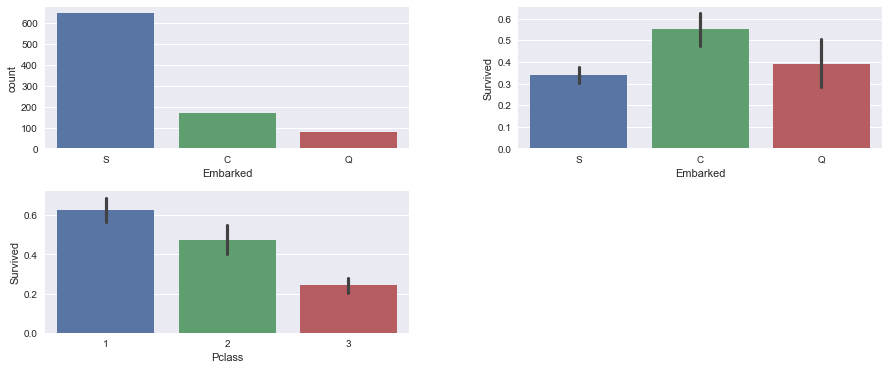

people embarked at Cherbourg has the highest survival compare to others.
Higher Pclass (1st class) survived more


In [5]:
fig = plt.figure(figsize=(15,6))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
ax1 = fig.add_subplot(221)
sns.countplot(x=titanic['Embarked'])

ax2 = fig.add_subplot(222)
sns.barplot(data=titanic, x='Embarked', y='Survived')

ax3 = fig.add_subplot(223)
sns.barplot(data=titanic, x='Pclass', y='Survived')

plt.show()
print("people embarked at Cherbourg has the highest survival compare to others.")
print("Higher Pclass (1st class) survived more")

In [6]:
# we only need Fare, Sex, Pclass and Embarked
drop = ['PassengerId', 'Age', 'SibSp', 'Parch']
titanic = titanic.drop(drop, axis=1)
print(titanic)

     Pclass     Fare  Sex_male Embarked  Survived
0         3   7.2500         1        S         0
1         1  71.2833         0        C         1
2         3   7.9250         0        S         1
3         1  53.1000         0        S         1
4         3   8.0500         1        S         0
..      ...      ...       ...      ...       ...
886       2  13.0000         1        S         0
887       1  30.0000         0        S         1
888       3  23.4500         0        S         0
889       1  30.0000         1        C         1
890       3   7.7500         1        Q         0

[891 rows x 5 columns]


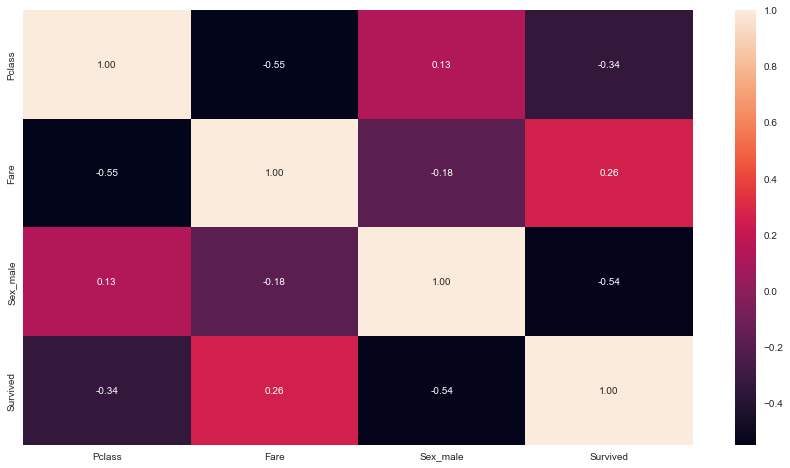

Survived has strong correlation with Fare and Pclass


In [7]:
# Correlation matrix:
def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    rcParams['figure.figsize'] = 15, 8
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

plot_correlation(titanic) 
    
print("Survived has strong correlation with Fare and Pclass")

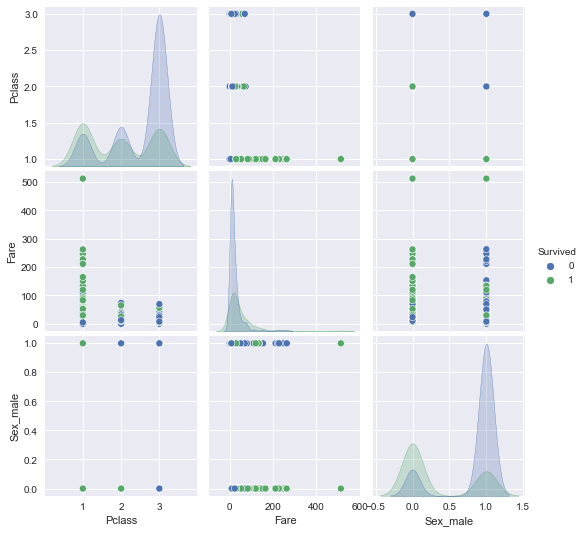

In [8]:
# Scatter matrix
sns.pairplot(data=titanic, hue='Survived')

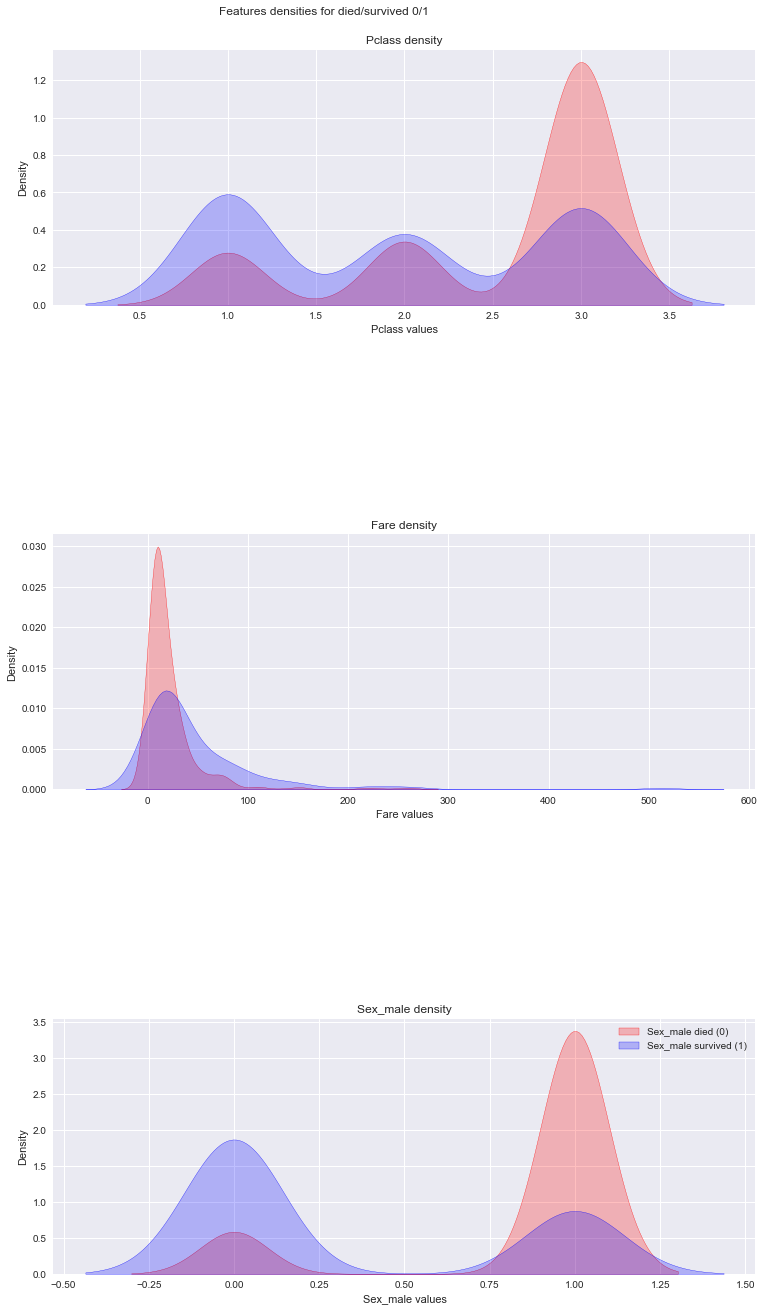

From the graphs it can be seen that Fare, Pclass and gender affects survival quite a bit as the curves are not overlapping


In [9]:
# Density plots
def plot_densities(data):
    '''
    Plot features densities depending on the survived values
    '''
    # change fig size
    rcParams['figure.figsize'] = 15, 20
    # separate data based on outcome values 
    died = titanic[titanic['Survived'] == 0]
    survived = titanic[titanic['Survived'] == 1]
    # initiate figure
    fig, axs = plt.subplots(3, 1)
    fig.suptitle('Features densities for died/survived 0/1')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)
    # plot densities for outcomes
    # drop the last col (survived) to avoid singular matrix error
    # which would give perfect correlation
    for column_name in names[:-2]:
        ax = axs[names.index(column_name)]
        sns.kdeplot(died[column_name], shade=True, label=column_name + ' died (0)', 
                    ax=ax, color='red', legend=True)
        sns.kdeplot(survived[column_name],shade=True, label=column_name + ' survived (1)', 
                    ax=ax, color='blue', legend=True)
        ax.set_xlabel(column_name + ' values')
        ax.set_title(column_name + ' density')
        ax.grid('on')
    plt.legend()
    plt.show()

titanic_copy = titanic.copy()
titanic_copy.drop(['Survived'], axis=1)
names = list(titanic_copy.columns)
plot_densities(titanic)
print("From the graphs it can be seen that Fare, Pclass and gender affects survival quite a bit as the curves are not overlapping")

In [10]:
# Scaling the data
titanic_scaled = titanic.copy()

scaler = StandardScaler()
# scale fare because they have a lot range
cols = ['Fare']
titanic_scaled[cols] = scaler.fit_transform(titanic[cols])
titanic_scaled.head()

,Pclass,Fare,Sex_male,Embarked,Survived
0,3,-0.502445,1,S,0
1,1,0.786845,0,C,1
2,3,-0.488854,0,S,1
3,1,0.420730,0,S,1
4,3,-0.486337,1,S,0


In [11]:
# Selecting the features
X = np.array(titanic_scaled[['Pclass', 'Sex_male', 'Fare']]) # feature variables
y = np.array(titanic_scaled['Survived']) # target variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

# Model Development and evaluations
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg_model = logreg.fit(X_train, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

print("Intercept :", logreg.intercept_)
print("Attributes Coefficients Dictionary: ",  logreg.coef_)

y_pred = logreg_model.predict(X_test)
# y_pred == y_test

Training set score: 0.789
Test set score: 0.777
Optimization terminated successfully.
         Current function value: 0.522247
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                  0.2157
Time:                        19:11:04   Log-Likelihood:                -465.32
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 2.557e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2160      0.049      4.413      0.000      

In [12]:
sum(y_pred == y_test)

139

In [13]:
len(y_pred == y_test)

179

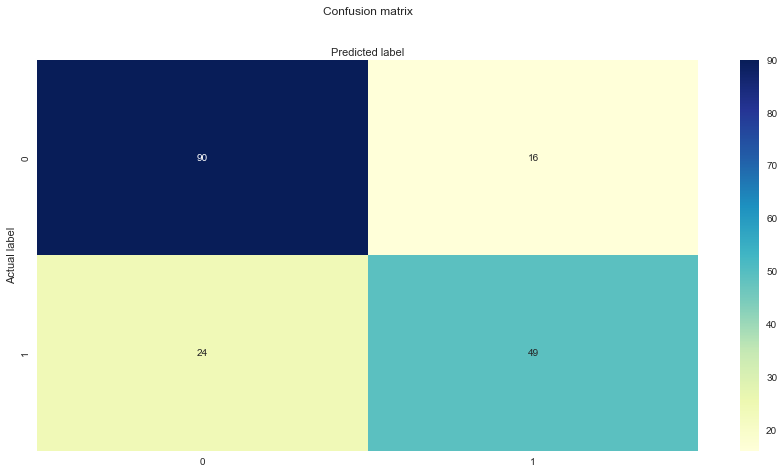

Accuracy: 0.776536312849162
Precision: 0.7538461538461538
Recall: 0.6712328767123288
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       106
           1       0.75      0.67      0.71        73

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179



In [14]:
# Model evaluation using Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

# Visualising confusion matrix using heatmap
rcParams['figure.figsize'] = 12, 6
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Metrics evaluation (precision, recall, accuracy)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

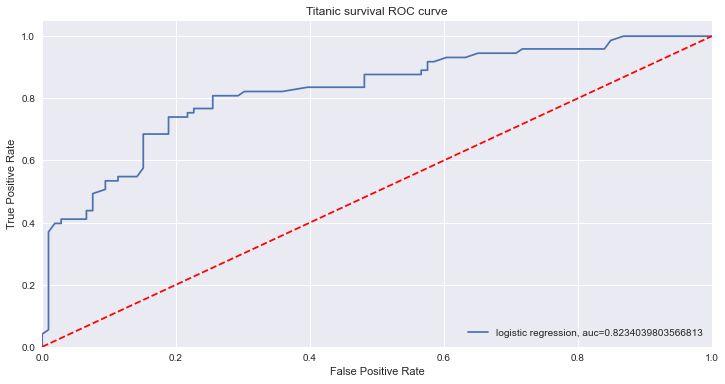

In [15]:
# ROC curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
# tp is true positives, fp is false positives
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr,tpr,label="logistic regression, auc="+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic survival ROC curve')
plt.legend(loc=4)
plt.show()

#### 1.3 Result Analysis

As with prediction, a positive coefficient indicates that a higher predictor leads to a higher probability of the target variable being 1. For example, you might find that the coefficient for `Pclass` is negative - this is because a lower `Pclass` value (eg. First Class) leads to a higher chance of survival. **Unlike linear regression, this doesn't translate directly**; a coefficient of 1.5 does not mean a probability increase of 150%. Instead, it is a **transformation** of the original linear regression formula. If you're interested in learning more, we encourage you to do some online research. As a starting point, try <a href="https://machinelearningmastery.com/logistic-regression-for-machine-learning/">this link</a>. It's likely that you'll study logistic regression in much further detail in future courses at ANU.

Please answer the following questions in the text box:
1. **Find the coefficient for each predictor and describe its effect** (positive, negative, or insignificant) on survivability. You can (and should) also compare coefficients between predictors (eg. age has a stronger effect than class on survivability).
2. Do you think that Logistic Regression is a suitable model for the titanic data? Is it overfitting or underfitting? Why? You should consider looking at the training and test scores.

#### 1.4 What About Me?
Now here's the important question - would you have survived on the Titanic?

For each predictor in your model, decide what the value would be for you, pretending that you time travelled to 1912. For `Age` and `Sex` this would be easy, but you'll have to guess what your passenger class would be. If you'd instead prefer to predict the survivability of someone else (or in addition to yourself), consider your favourite TV show, movie or game character.

Then, use the `logres_model.predict()` function to find out what your survivability would be. You'll likely run in to errors for this function; ensure that the data you give it is in the correct format.


In [17]:
myself = [3, 1, 20]
pred =logreg_model.predict(np.array([myself]))
print("You could survive! Yeah :)" if pred==1 else "It seemed that you couldn't survive :(")

It seemed that you couldn't survive :(


### Exercise 2: In The Neighbourhood
The second classification technique we'll learn is **k-Nearest Neighbour**, often shortened to kNN. The general idea (at least, for 1-Nearest Neighbour), is that you make the model memorise all the training data, and when you get a new point for prediction, you match it to the "most similar" point in the training set and give it the same label. For kNN, we compare it to the k most similar training points and give it the most common label amongst those points.

#### 2.1 Scaling Data, Not Fish
Consider two features, `Pclass` and `Age`, and two points:
1. `Pclass`=1, `Age`=40, `Survived`=1
2. `Pclass`=3, `Age`=20, `Survived`=0

You've likely found that `Pclass` is far more important predictor than `Age` - passengers with First Class tickets were more likely to board lifeboats, and thus had a higher chance of surviving. However, `Pclass` has a range of 1-3 while `Age` has a range of 0-80. For k-Nearest Neighbours, this means that comparing to a point like `Pclass`=1, `Age`=20, thus `Survived`=1, the first point above would have a distance of 20 while the second point would have a distance of 2.

This is why we need to **scale data**, so that the range of a predictor doesn't affect its distance. To do this, we can use the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler">StandardScaler module in Scikit learn</a>.

Because we don't know what the testing data looks like, it would be improper to scale depending on the range of the testing data. So, implement the following:
1. Using a StandardScaler instance, **fit and transform only the training data**, naming the transformed data `train_scaled`. 
2. Then, using the same instance, **transform the testing data separately** (without re-fitting) and name it `test_scaled`.

We print the mean and variance of `train_scaled` and `test_scaled` for you. Even you get it worked properly, you might find that, for the training set, they aren't *exactly* 0 and 1, but any difference is insignificant. You should have found a different mean and variance for the scaled testing set; this is because we used the distribution of the training set to scale the testing set.

In [19]:
# Scaling the data
titanic_scaled = titanic.copy()

scaler = StandardScaler()
# scale fare because they have a lot range
cols = ['Fare']
titanic_scaled[cols] = scaler.fit_transform(titanic[cols])
titanic_scaled.head()

# Encoding Embarked
labelEncoder = LabelEncoder()
titanic.iloc[:, 3] = labelEncoder.fit_transform(titanic.iloc[:, 3].values)

X = titanic.iloc[:, 1:5].values
y = titanic.iloc[:, 4].values

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

print('Scaled train data mean: ', titanic_scaled.mean())
print('Scaled train data variance: ', titanic_scaled.var())


Scaled train data mean:  Pclass      2.308642e+00
Fare       -4.373606e-17
Sex_male    6.475870e-01
Embarked    1.536476e+00
Survived    3.838384e-01
dtype: float64
Scaled train data variance:  Pclass      0.699015
Fare        1.001124
Sex_male    0.228475
Embarked    0.626477
Survived    0.236772
dtype: float64


Find the types of `train_scaled` and `test_scaled` - you'll notice that the scaling module doesn't return a Pandas DataFrame. So that we can apply the same machine learning modules as we have before, convert both of these objects back to Pandas DataFrames, and ensure that their columns are named appropriately. （Hint: renaming columns can be done without explicitly typing out each column name.）

#### 2.2 Getting To Know Your Neighbours
Look at the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">documentation for Scikit-Learn's kNN Classifier</a>, or use `help(KNeighborsClassifier)`.

Let's continue using the Titanic dataset for predicting survival. Just like you did for logistic regression, 
1. **Create an instance of the KNeighborsClassifier**. For now, set `n_neighbors=5` (i.e. $k=5$). 、
2. Then fit the model and name it `knn_model`. As the instance expects the target variable to have integer values, give it the non-scaled target column for the `y` argument.
3. Now find the **training and testing scores** for this model (rounding to two decimal places). Compare this testing score to the testing score you obtained for logistic regression earlier, and also compare your score with other students.

In [24]:
# TODO: KNN classifier

def accuracy(k, X_train, y_train, X_test, y_test):
    '''
    compute accuracy of the classification based on k values 
    '''
    # instantiate learning model and fit data
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', algorithm='kd_tree')
    knn.fit(X_train, y_train)
    
    # predict the response
    y_pred = knn.predict(X_test)
    
    #evaluate and return accuracy
    return metrics.accuracy_score(y_test, y_pred)

n_neighbors = 1

# fit and score the model
k_range = range(1, 36)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # Predict
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print(np.array(scores))

print("Training Score:", knn.score(X_train, y_train))
print("Test score: ", knn.score(X_test, y_test))
# print results
print('----------------------------------------------------------------------')
print('Classification report')
print('----------------------------------------------------------------------')
print('\n', classification_report(y_test, y_pred))
print('----------------------------------------------------------------------')
print('Accuracy = %5s' % round(accuracy(n_neighbors, X_train, y_train, X_test, y_test), 3))
print('----------------------------------------------------------------------')

[0.96648045 0.9273743  0.94413408 0.92178771 0.9273743  0.91620112
 0.92178771 0.90502793 0.91620112 0.90502793 0.91620112 0.90502793
 0.89385475 0.88826816 0.88268156 0.87709497 0.87709497 0.8603352
 0.8603352  0.8547486  0.8603352  0.86592179 0.8547486  0.84357542
 0.84916201 0.84357542 0.84916201 0.83240223 0.82122905 0.81564246
 0.81005587 0.79329609 0.79888268 0.78212291 0.79888268]
Training Score: 0.8160112359550562
Test score:  0.7988826815642458
----------------------------------------------------------------------
Classification report
----------------------------------------------------------------------

               precision    recall  f1-score   support

           0       0.81      0.86      0.83       106
           1       0.78      0.71      0.74        73

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

-------------------------------------------------

Text(0, 0.5, 'Testing Accuracy')

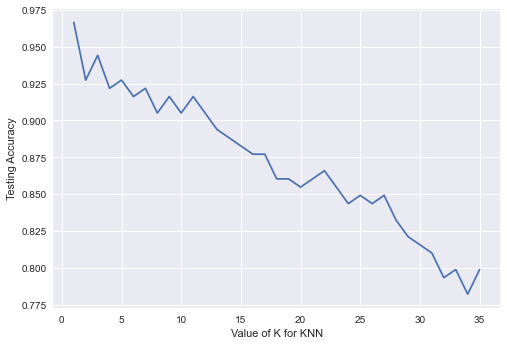

In [127]:
# Data Visualisation
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [128]:
y_pred = knn.predict(X_test)
sum(y_pred == y_test)

143

In [129]:
len(y_pred == y_test)

179

#### 2.3 How Big Should Our Neighbourhood Be?
Earlier, we used `n_neighbors=5` when creating the kNN instance. Try increasing or decreasing this parameter and see how it affects the model performance. Note that `k` is a hyperparameter of knn, so to avoid overfitting to the test set, we need:
1. firstly **create a validation set**. 
2. **Find the best `k` on the validation set and evaluate the model with the best `k` on the test set**. You can either adjust the code you wrote previously, or copy it here and adjust it. 

In [23]:
titanic.shape[0]

891

In [21]:
%%time
rows_nbr = 891 # data.shape[0]
best_n_neighbours = np.argmax(np.array([accuracy(k, X_train, y_train, X_test, y_test) for k in range(1, int(rows_nbr/2))])) + 1
print('For best accuracy use k = ', best_n_neighbours)

For best accuracy use k =  1
Wall time: 3.58 s


In [131]:
# Cross Validating
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
# Predict
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

# cross-validation score
score = cross_val_score(knn, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy')
print(score.mean())

0.9664804469273743
0.9353286384976526


Ref:
[1] https://medium.com/@svanillasun/how-to-deal-with-cross-validation-based-on-knn-algorithm-compute-auc-based-on-naive-bayes-ff4b8284cff4

In [132]:
scoreP = round(np.mean(score)*100, 2)
print('Our KNN classifier score is ' + str(scoreP) + '%')

Our KNN classifier score is 93.53%


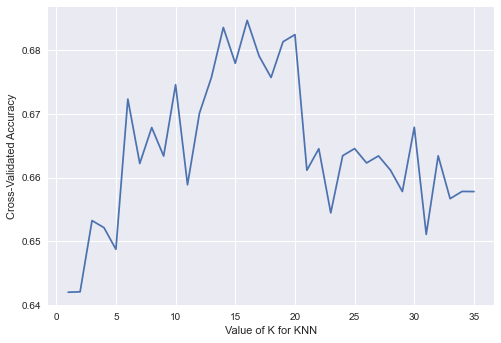

Since it is showing MSE, we need to find the smallest value which is between (1, best k). 


In [133]:
# Plot cross validated accuracy
# choose k between 1 to 36
k_range = range(1, 36)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
print("Since it is showing MSE, we need to find the smallest value which is between (1, best k). ")

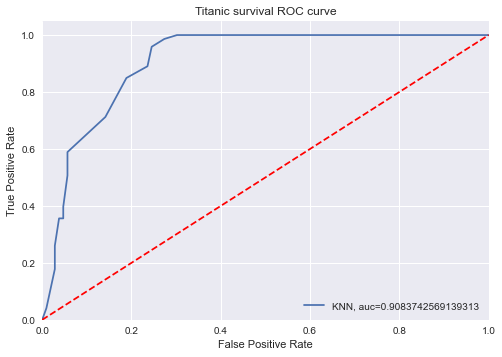

In [136]:
# We can score a binary classification is by plotting the receiver operating characteristic
# and determining the value of the area under curve (AUC). Again, our goal is to see an 
# AUC as close to 1 as possible.
# Finding the false positive and true positive rates where the positive label is 2.
knn.fit(X_train, y_train)
y_pred_proba = knn.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic survival ROC curve')
plt.legend(loc=4)
plt.show()


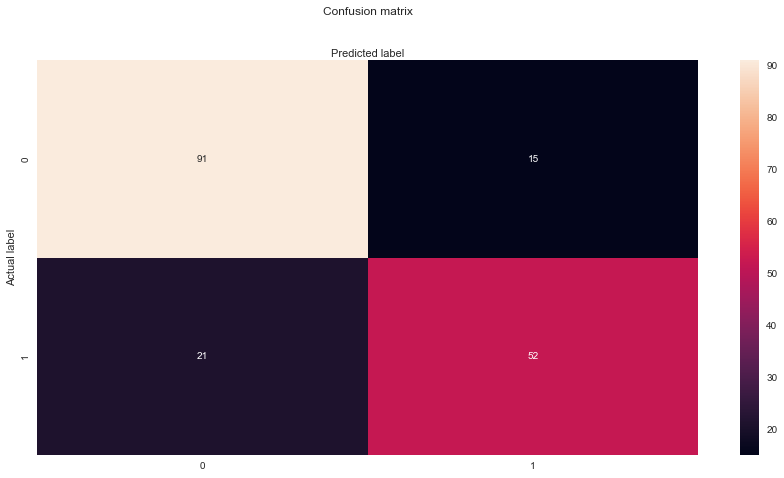

In [73]:
# Confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)), annot=True)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


What's the best choice of parameter value? Try NOT to fine-tune it too much (as this can lead to overfitting in your model, and you shouldn't be using the testing score to adjust your model). 

What would happen when we set `n_neighbors=N`, where `N` is the number of entries in the training set? Alternatively, what about `n_neighbors=1`? (Hint: think about what a small difference in the predictors values of a new point would cause.)

### Exercise 3: Classifying Flowers
It's likely that you found a higher testing score, and a much more accurate training score, for logistic regression than for kNN. However, as we've mentioned before, (binary) logistic regression has a major pitfall: it can only classify two-class variables.

Of course, we can use an advanced form of logistic regression, called Multinomial Logistic Regression (not to be confused with Multiple Linear Regression), but the theory for that technique is beyond the scope of this course. Instead, we'll simply use **kNN** here for multi-class classification.

Let's go back to the Iris dataset. Your tasks are as follows:

1. **Import and explore the data** (`data/IRIS.csv`) so that you're familiar with it (if you're not already).
2. As you did with the Titanic dataset, **transform the data** as necessary,
3. **split the data** into training and testing (80-20, ensuring that each set is representative of the whole dataset), 
4. **scale the data** according to the training set distribution, 
5. **fit a new model** using a new instance of the kNN classifier, and finally **find the training and testing scores** of the model with this data.

You could feel free to use the previously-written helper functions for the tasks.

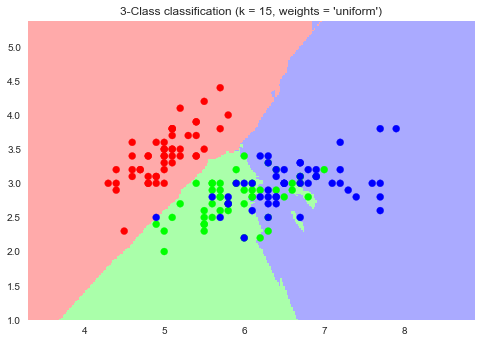

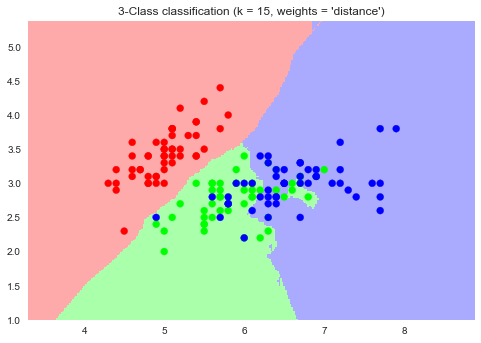

In [147]:
# TODO: your code here

from sklearn import neighbors, datasets
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

If you did everything right, you should be getting fairly high scores. Run the code a few times using different, random train-test partitions to get a better understanding of the average score.

### Exercise 4: Confusing You Some More
We've explored the default mean accuracy score (using `model.score()`), but classification also has other important scoring techniques that are useful for diagnosing your model. To start off, let's **create a confusion matrix** using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html">Scikit-Learn's Confusion Matrix module</a>. Using the testing data for the Titanic dataset and the logistic regression model you created, produce a confusion matrix. Ensure that you give the function the right parameter values (use `help(confusion_matrix)` if needed). (Hint: you'll need to use the `model.predict()` function to create `y_pred`.)

In [ ]:
# TODO: create confusion matrix


That's a pretty confusing (pun intended) set of numbers there. What do they mean?

The confusion matrix is made up of $n$ columns and $n$ rows, where $n$ is the number of target levels you have (2 for the Titanic dataset). The rows indicate the observations, or actuals, while the columns indicate the predicted, starting from the lowest level. Specifically, if $C$ is the confusion matrix, then $C_{0,0}$ is the **true negatives** (predicted negative, actually negative), $C_{0,1}$ is the **false positives** (predicted positive, actually negative), $C_{1,0}$ is the **false negatives** (predicted negative, actually positive) and $C_{1,1}$ is the **true positives** (predicted positive, actually positive). As we want correct predictions, we want $C_{0,0}$ and $C_{1,1}$ (i.e. values on the main diagonal) to be as large as possible. The documentation for this module also explains this.

Re-produce the confusion matrix, but this time save it to four new objects by using `tn, fp, fn, tp = ...` and using the `ravel()` function (the `confusion_matrix()` documentation has an example of this). This will keep a record of each of the four numbers described above. We've provided a (crude) way of show the confusion matrix counts, their labels, counts and sums; if you've completed the previous steps correctly you should be able to just run this.

In [ ]:
# TODO: save confusion matrix counts

print("                 PREDICTION")
print("                __0_____1__")
print("OBSERVATION  0 |", str(tn).rjust(2), "  ", str(fp).rjust(2), "|", tn+fp)
print("             1 |", str(fn).rjust(2), "  ", str(tp).rjust(2), "|", fn+tp)
print("               ------------")
print("                ", tn+fn, "  ", fp+tp, " ", tn+fp+fn+tp)

Now you can compare the predictions and observations. If your model is behaving unexpectedly, you can use the confusion matrix to easily determine whether the model is only predicting one label. Confusion matrices are also important if you especially want to avoid a particular type of incorrect prediction. For example, a cancer screening that incorrectly classifies a person as not having cancer when they do have cancer is life-threatening, so you'd want to alter your model to avoid that.

Now let's calculate a few different scoring metrics:
- **Recall**: TP / (TP + FN). This describes the proportion of actual-positive observations that were correctly classified.
- **Precision**: TP / (TP + FP). This is the percentage of positive-predicted observations that were correctly classified.
- **Accuracy**: (TP + TN) / (TP+FP+FN+TN). This is the percentage of correctly classified observations in total. This is the same as the `model.score()` function that we used earlier.
- **F1**: (2 * Recall * Prediction) / (Recall + Prediction). This is a weighted average of recall and precision, and generally a better metric than accuracy for data that is unbalanced with respect to its target labels.

**Find each of the scores above** for your Titanic logistic regression model.

In [ ]:
# TODO: calculate recall, precision, accuracy and F1 scores
recall = None # TODO
prec = None # TODO
acc = None # TODO
f1 = None # TODO
print("Recall:   ", recall,
    "\nPrecision:", prec,
    "\nAccuracy: ", acc,
    "\nF1 Score: ", f1)

Have a look through these scores and understand what they mean for your model. Are these scores fairly similar? If not, how come?

Re-fit the kNN model for the Titanic dataset (especially if you've played around with the `n_neighbors` parameter), and repeat the above steps to **calculate the four metrics for the kNN model**. Compare the two models' metrics.

In [ ]:
# TODO: repeat for kNN model


What happens to the confusion matrix if you change the `n_neighbors` parameter to be equal to the size of the training data? Fit the kNN model with `n_neighbors=N`, where `N` is the size of the training set, and view the output of the confusion matrix.

In [ ]:
# TODO: change n_neighbors and look at confusion matrix


Check that the output for the confusion matrix matches with your answer to the previous question when you were adjusting the `n_neighbors` parameter.

*****

## Homework & Extension Questions
You will need to complete previous exercises before starting these exercises.

### Exercise 4: Scaled or Un-Scaled?
In an earlier exercise, we showed that scaling was necessary for the kNN classifier. Now, for both the Titanic and Iris datasets, **fit new models using un-scaled data** and compare the predictive scores. What do you find?

In [ ]:
# TODO: fit un-scaled kNN model for Titanic and compare


In [ ]:
# TODO: fit un-scaled kNN model for Iris and compare


For one of these, you'll find a noticeable improvement in the performance, while the other might be more or less the same as when you used scaled data. Investigate the datasets and **figure out why scaling has a larger impact on one model**. *Hint: look at the descriptive statistics for both datasets. Which statistic(s) are most relevant?*

### Exercise 5: Looking In The Grey Area
Logistic regression has another advantage that we haven't mentioned: it can produce a "reliable" *probability* of success, rather than a black-and-white "success or fail" output. While the kNN classifier can also do this (by comparing the targets of its nearest neighbours), this isn't as reliable and it depends heavily on the `n_neighbors` parameter.

Have a look at the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">documentation for the Logistic Regression module</a> again (or use `help(LogisticRegression)`) and find out which function can be used to calculate the probability of success.

Then, repeat the prediction for yourself and/or a character, and **report the probability of survival**. If you had to guess some of the predictor values for that person, try altering them slightly and see how it affects the probability.

In [ ]:
# TODO: find probability of survival for yourself and/or a character
